In [1]:
import time, math, os, json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

# ===== CONFIG =====
STEPS = 20000          # comparable budget
BATCH_SIZE = 128
LATENT_DIM = 32
LR = 1e-3
SEED = 42
OUT_DIR = "vae_run_notebook"
os.makedirs(OUT_DIR, exist_ok=True)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_name = "cpu" if device.type=="cpu" else f"cuda:{torch.cuda.get_device_name(0)}"
device, device_name


(device(type='cpu'), 'cpu')

In [2]:
tfm = transforms.Compose([transforms.ToTensor()])  # MNIST in [0,1]
train_ds = datasets.MNIST(root=os.path.join(OUT_DIR, "data"), train=True, download=True, transform=tfm)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
                          num_workers=2, pin_memory=(device.type=="cuda"))

fixed_batch, _ = next(iter(train_loader))
fixed_batch = fixed_batch[:64].clone()  # for recon grid
fixed_batch.shape


100%|██████████| 9.91M/9.91M [00:00<00:00, 129MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 40.1MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 112MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.09MB/s]


torch.Size([64, 1, 28, 28])

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.latent_dim = latent_dim
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))  # in [0,1]

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    # BCE recon + KL(q(z|x)||N(0,I)), summed over pixels
    recon = F.binary_cross_entropy(recon_x, x, reduction="sum")
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total = recon + kl
    return total, recon, kl

model = VAE(LATENT_DIM).to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR)

sum(p.numel() for p in model.parameters())


667248

In [4]:
model.train()
step = 0
loss_steps = []
loss_vals = []

t0 = time.time()

while step < STEPS:
    for x, _ in train_loader:
        if step >= STEPS:
            break
        x = x.to(device, non_blocking=True).view(-1, 28*28)

        recon, mu, logvar = model(x)
        total, recon_l, kl_l = vae_loss(recon, x, mu, logvar)

        opt.zero_grad(set_to_none=True)
        total.backward()
        opt.step()

        step += 1

        # per-batch (divide by batch size for readable number)
        total_pb = total.detach().item() / x.size(0)
        if step == 1 or step % 50 == 0 or step == STEPS:
            loss_steps.append(step)
            loss_vals.append(total_pb)
            print(f"[step {step:>6}/{STEPS}] total={total_pb:.3f}")

wall_sec = time.time() - t0
wall_min = wall_sec / 60
wall_min


[step      1/20000] total=547.786
[step     50/20000] total=215.546
[step    100/20000] total=199.859
[step    150/20000] total=163.805
[step    200/20000] total=153.532
[step    250/20000] total=152.839
[step    300/20000] total=146.922
[step    350/20000] total=140.100
[step    400/20000] total=131.782
[step    450/20000] total=128.468
[step    500/20000] total=127.886
[step    550/20000] total=130.616
[step    600/20000] total=126.083
[step    650/20000] total=127.004
[step    700/20000] total=121.201
[step    750/20000] total=124.387
[step    800/20000] total=122.368
[step    850/20000] total=122.901
[step    900/20000] total=120.582
[step    950/20000] total=120.660
[step   1000/20000] total=118.110
[step   1050/20000] total=119.548
[step   1100/20000] total=116.626
[step   1150/20000] total=112.411
[step   1200/20000] total=114.155
[step   1250/20000] total=116.846
[step   1300/20000] total=115.338
[step   1350/20000] total=118.709
[step   1400/20000] total=113.805
[step   1450/2

11.991492807865143

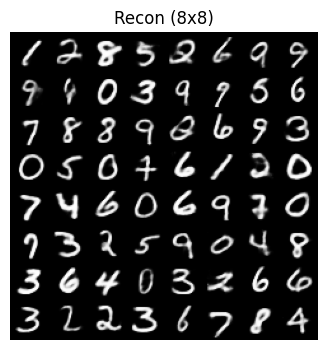

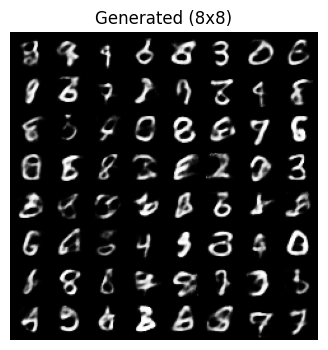

In [5]:
@torch.no_grad()
def save_and_show_grids():
    model.eval()
    # recon
    x = fixed_batch.to(device).view(-1, 28*28)
    recon, _, _ = model(x)
    recon = recon.view(-1, 1, 28, 28)
    recon_grid = make_grid(recon[:64], nrow=8, padding=2)
    recon_path = os.path.join(OUT_DIR, "vae_recon_8x8.png")
    save_image(recon_grid, recon_path)

    # generate
    z = torch.randn(64, LATENT_DIM, device=device)
    gen = model.decode(z).view(-1, 1, 28, 28)
    gen_grid = make_grid(gen, nrow=8, padding=2)
    gen_path = os.path.join(OUT_DIR, "vae_generated_8x8.png")
    save_image(gen_grid, gen_path)

    # display
    plt.figure(figsize=(4,4)); plt.imshow(recon_grid.permute(1,2,0).cpu()); plt.axis("off"); plt.title("Recon (8x8)")
    plt.figure(figsize=(4,4)); plt.imshow(gen_grid.permute(1,2,0).cpu()); plt.axis("off"); plt.title("Generated (8x8)")
    plt.show()

save_and_show_grids()


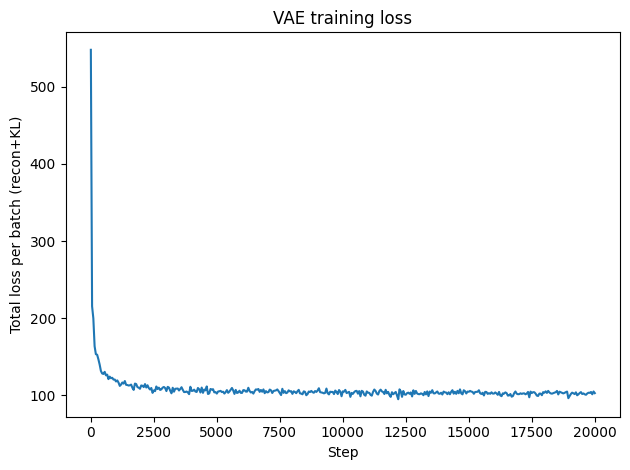

'vae_run_notebook/vae_loss_curve.png'

In [6]:
plt.figure()
plt.plot(loss_steps, loss_vals)
plt.xlabel("Step")
plt.ylabel("Total loss per batch (recon+KL)")
plt.title("VAE training loss")
plt.tight_layout()
loss_path = os.path.join(OUT_DIR, "vae_loss_curve.png")
plt.savefig(loss_path, dpi=150)
plt.show()

loss_path

In [7]:
params = sum(p.numel() for p in model.parameters())
summary = {
    "model": "VAE (MLP)",
    "dataset": "MNIST",
    "steps": STEPS,
    "batch_size": BATCH_SIZE,
    "latent_dim": LATENT_DIM,
    "lr": LR,
    "seed": SEED,
    "device": device_name,
    "wall_clock_minutes": round(wall_min, 2),
    "final_loss_per_batch": round(loss_vals[-1], 3),
    "params": int(params),
    "artifacts": {
        "generated": os.path.join(OUT_DIR, "vae_generated_8x8.png"),
        "recon": os.path.join(OUT_DIR, "vae_recon_8x8.png"),
        "loss_curve": os.path.join(OUT_DIR, "vae_loss_curve.png"),
    }
}
summary_path = os.path.join(OUT_DIR, "run_summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

summary, summary_path

({'model': 'VAE (MLP)',
  'dataset': 'MNIST',
  'steps': 20000,
  'batch_size': 128,
  'latent_dim': 32,
  'lr': 0.001,
  'seed': 42,
  'device': 'cpu',
  'wall_clock_minutes': 11.99,
  'final_loss_per_batch': 103.027,
  'params': 667248,
  'artifacts': {'generated': 'vae_run_notebook/vae_generated_8x8.png',
   'recon': 'vae_run_notebook/vae_recon_8x8.png',
   'loss_curve': 'vae_run_notebook/vae_loss_curve.png'}},
 'vae_run_notebook/run_summary.json')